In [1]:
!git clone https://github.com/jacobgil/pytorch-grad-cam.git

Cloning into 'pytorch-grad-cam'...
remote: Enumerating objects: 1097, done.
remote: Total 1097 (delta 0), reused 0 (delta 0), pack-reused 1097
Receiving objects: 100% (1097/1097), 110.14 MiB | 14.33 MiB/s, done.
Resolving deltas: 100% (610/610), done.
Updating files: 100% (111/111), done.


In [2]:
!ls

pytorch-grad-cam  sample_data


In [3]:
%cd pytorch-grad-cam/

/content/pytorch-grad-cam


In [4]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# !pip install -U --no-cache-dir gdown --pre
# Let us download YOLOv8 trained model - https://archive.org/details/deep_sea_net
!wget https://archive.org/download/deep_sea_net/best_yolov8.pt

--2023-04-26 18:26:45--  https://archive.org/download/deep_sea_net/best_yolov8.pt
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia601604.us.archive.org/21/items/deep_sea_net/best_yolov8.pt [following]
--2023-04-26 18:26:46--  https://ia601604.us.archive.org/21/items/deep_sea_net/best_yolov8.pt
Resolving ia601604.us.archive.org (ia601604.us.archive.org)... 207.241.227.84
Connecting to ia601604.us.archive.org (ia601604.us.archive.org)|207.241.227.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14292605 (14M) [application/octet-stream]
Saving to: ‘best_yolov8.pt’

best_yolov8.pt      100%[===================>]  13.63M  4.28MB/s    in 3.2s    

2023-04-26 18:26:50 (4.28 MB/s) - ‘best_yolov8.pt’ saved [14292605/14292605]



In [6]:
!pwd

/content/pytorch-grad-cam


In [7]:
!ls

best_yolov8.pt	LICENSE		  README.md	    setup.py   usage_examples
cam.py		pyproject.toml	  requirements.txt  tests
examples	pytorch_grad_cam  setup.cfg	    tutorials


In [8]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img



In [9]:
!pwd

/content/pytorch-grad-cam


In [10]:
!mkdir cam_outputs

In [11]:
import os

model = torch.hub.load('ultralytics/yolov5', 'custom', 'best_yolov8.pt')  # custom/local model

# model = torch.load("best.pt")
model.eval()
model.cpu()
target_layers = [model.model.model.model[-3]]

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-4-26 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)



requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
Model summary: 157 layers, 7026307 parameters, 0 gradients
Adding AutoShape... 


In [12]:
# for each_image in os.listdir('all_images'):
  # img = np.array(Image.open(requests.get(image_url, stream=True).raw))
image_url = "https://dl3.pushbulletusercontent.com/66kPlQxVqMfK4iveT1UdnZ5goVILj62m/fish-school.jpg" # fish school
# image_url = "https://dl3.pushbulletusercontent.com/fEmXpK5uMZMu80Ex6CGpYKLBMeSehJP3/fshbig.png" # fish big

img = np.array(Image.open(requests.get(image_url, stream=True).raw))
# img = np.array(Image.open(filename))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)
results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
img = Image.fromarray(detections)
img.save('o1.jpg', 'JPEG')



In [14]:


# img = np.array(Image.open(filename))
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255

cam = EigenCAM(model, target_layers, use_cuda=False)
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
img=Image.fromarray(cam_image)
img.save('o2.jpg', 'JPEG')

In [15]:
def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes



In [16]:


img = np.array(Image.open(requests.get(image_url, stream=True).raw))

# img = np.array(Image.open(filename))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
boxes, colors, names = parse_detections(results)
cam = EigenCAM(model, target_layers, use_cuda=False)
grayscale_cam = cam(tensor)[0, :, :]
renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
img1 = Image.fromarray(renormalized_cam_image)
img2 = Image.fromarray(np.hstack((rgb_img, cam_image, renormalized_cam_image)))
img1.save('o3.jpg', 'JPEG')
img2.save('o4.jpg', 'JPEG')

In [ ]:
# %cd /content/
# !zip -r /content/camdata.zip /content/pytorch-grad-cam
# from google.colab import files
# import time
# string = str(int(time.time()))
# os.rename("camdata.zip","exp_"+string+".zip")
# files.download("/content/"+"exp_"+string+".zip")

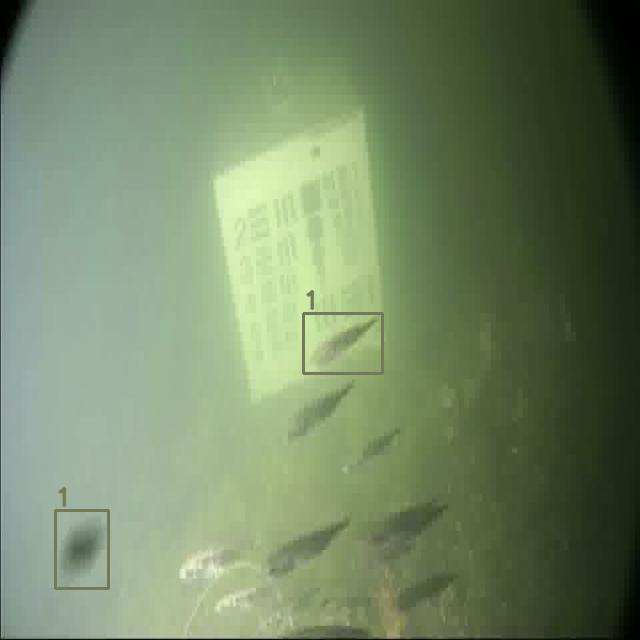

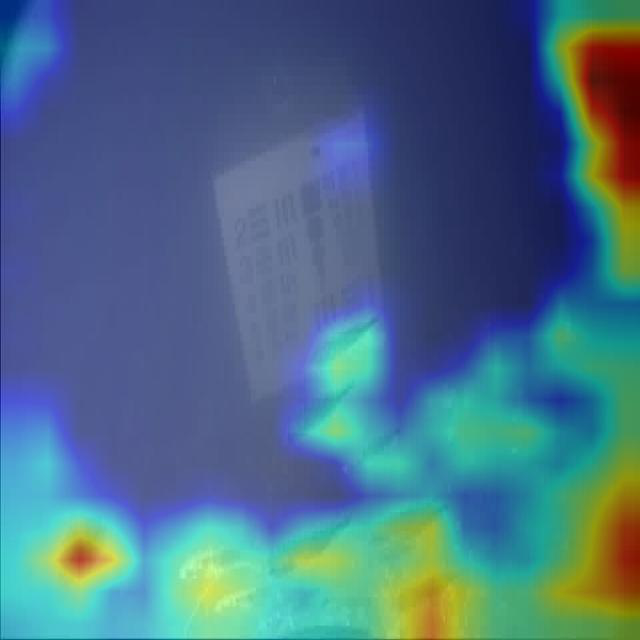

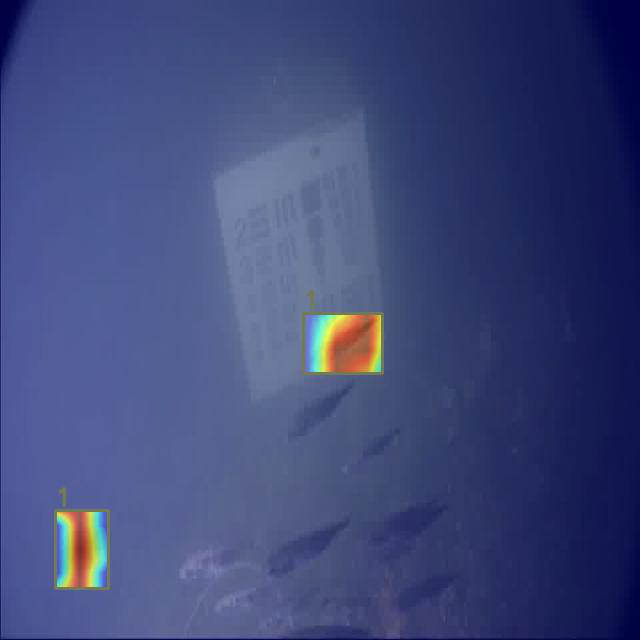

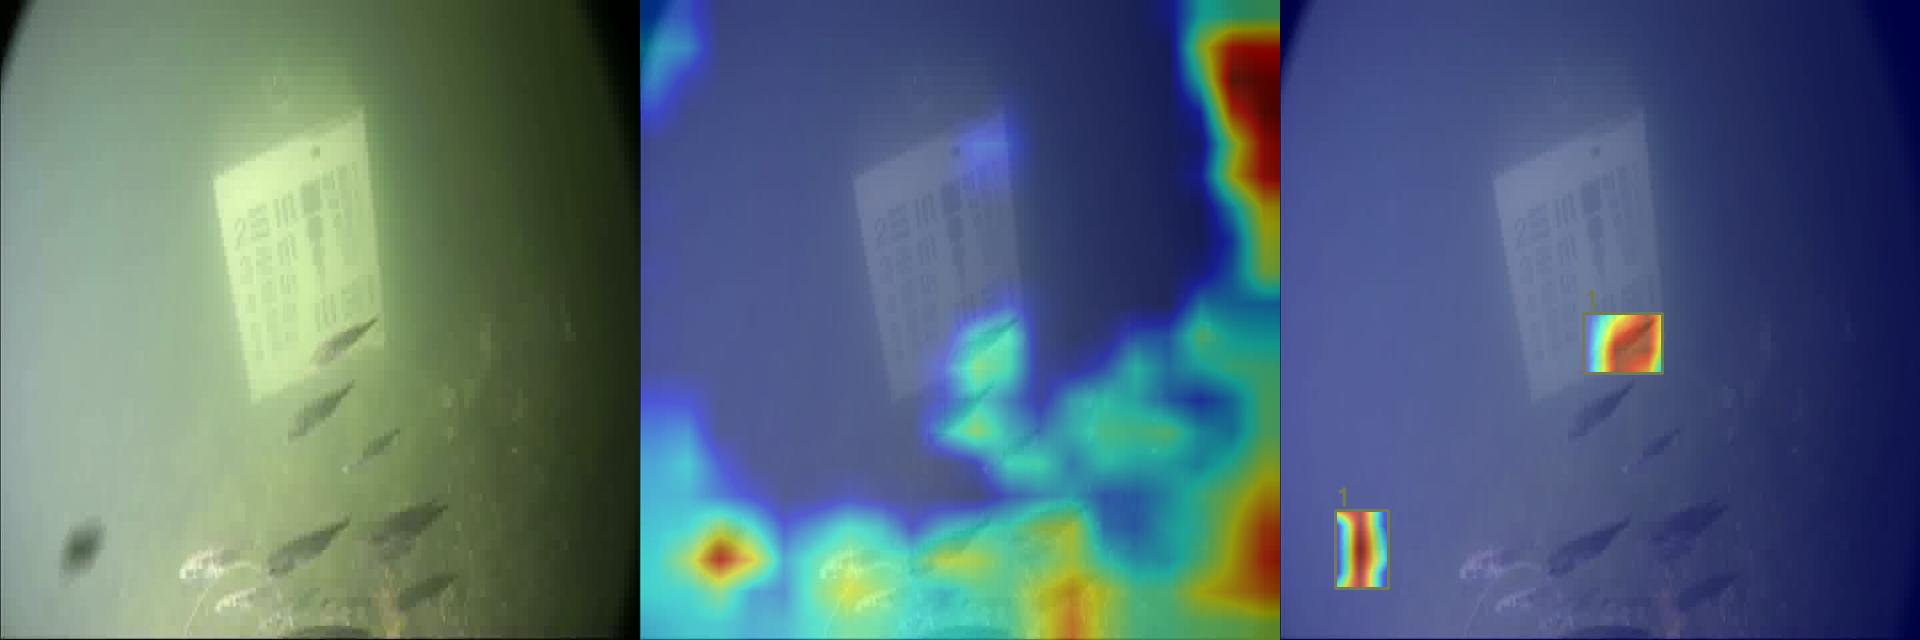

In [17]:
from PIL import Image
from IPython.display import display

# Load the images
img1 = Image.open('o1.jpg')
img2 = Image.open('o2.jpg')
img3 = Image.open('o3.jpg')
img4 = Image.open('o4.jpg')

# Display the images
display(img1, img2, img3, img4)
